In [ ]:
!pip install -r requirements.txt

In [ ]:
!pip install tensorflow

In [12]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [13]:
import warnings
warnings.filterwarnings("ignore")

#!pip install datasets

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
import tensorflow as tf
import torch
from torch.utils.data import DataLoader, Dataset

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
import re

from datasets import load_dataset, DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#

In [14]:
#============================ Read Preprocessed Data ============================#

#df = pd.read_csv('preprocessed_data.csv')
df = pd.read_csv('combined_dataset.csv')
df['text'] = df['text'].astype(str)

clean_text = list(df['text'])
labels = list(df['label'])

df

,text,label
0,it's not like terrorists want to incite things...,0
1,hahaha we can just trade you get my boobs and ...,1
2,That thing should be against the law,0
3,obama won that thing ? please,0
4,Do they not just burn that in an incinerator?,0
...,...,...
18953,That awkward moment Hen Zach would want a whol...,0
18954,That's what I'm saying and don't call me this.,0
18955,and smacked him upside his head with it .,1
18956,it was the usual gutless pieces of garbage who...,1


In [15]:
#============================ Tokenization ============================#

# Split into training, validation and test sets
train_texts, test_texts, train_labels, test_labels = train_test_split(clean_text, labels, test_size=0.2, random_state=42)
train_texts, val_texts, train_labels, val_labels = train_test_split(train_texts, train_labels, test_size=0.2, random_state=42)

# Loading pre-trained BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)
test_encodings = tokenizer(test_texts, truncation=True, padding=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [16]:
#============================ Defining a PyTorch Dataset ============================#

class CustomDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = CustomDataset(train_encodings, train_labels)
val_dataset = CustomDataset(val_encodings, val_labels)
test_dataset = CustomDataset(test_encodings, test_labels)

In [17]:
#============================ Loading the pre-trained Model ============================#

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# Defining optimizer
optimizer = AdamW(model.parameters(), lr=1e-5)

# Defining data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Training loop
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [19]:
#============================ Fine-tuning Model ============================#

import torch

# Early stopping parameters
patience = 3  # Number of epochs with no improvement after which training will be stopped
best_val_accuracy = 0.0
epochs_without_improvement = 0

for epoch in range(5):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_accuracy = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            outputs = model(input_ids, attention_mask=attention_mask)
            predictions = torch.argmax(outputs.logits, dim=1)
            val_accuracy += torch.sum(predictions == labels).item() / labels.size(0)

    avg_val_accuracy = val_accuracy / len(val_loader)
    print(f'Epoch {epoch + 1}, Validation Accuracy: {avg_val_accuracy}')

    # Check if validation accuracy improved
    if avg_val_accuracy > best_val_accuracy:
        best_val_accuracy = avg_val_accuracy
        epochs_without_improvement = 0  # Reset the counter
    else:
        epochs_without_improvement += 1

    # Early stopping condition: Stop training if no improvement for 'patience' epochs
    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        break



Epoch 1, Validation Accuracy: 0.9651315789473685
Epoch 2, Validation Accuracy: 0.9677631578947369
Epoch 3, Validation Accuracy: 0.9664473684210526
Epoch 4, Validation Accuracy: 0.9598684210526316
Epoch 5, Validation Accuracy: 0.9641447368421052
Early stopping triggered at epoch 5


In [20]:
#============================ Evaluating Model Performance ============================#

true_labels = []
predicted_labels = []

# Evaluation loop
model.eval()
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predictions.cpu().numpy())


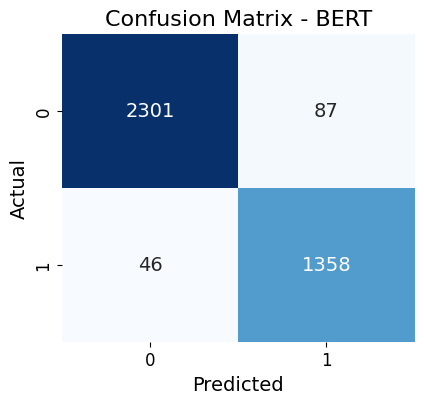


Classification Report:

                precision    recall  f1-score   support

  Appropriate       0.98      0.96      0.97      2388
Inappropriate       0.94      0.97      0.95      1404

     accuracy                           0.96      3792
    macro avg       0.96      0.97      0.96      3792
 weighted avg       0.97      0.96      0.97      3792


Evaluation Metrics:

Accuracy: 0.9649261603375527
Precision: 0.9397923875432526
Recall: 0.9672364672364673
F1-score: 0.9533169533169533


In [21]:
# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size": 14})
plt.title('Confusion Matrix - BERT', fontsize = 16)
plt.xlabel('Predicted', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()


# Classification report
target_names = ['Appropriate', 'Inappropriate']
print('\nClassification Report:\n\n', classification_report(true_labels, predicted_labels, target_names=target_names))

# Evaluation Metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
print("\nEvaluation Metrics:\n")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
#============================ Save the  model ============================#

model.save_pretrained('/content/drive/MyDrive/Colab_Notebooks/bert_model_new/')
model.save_pretrained('/bert_model/')

In [24]:
#============================ Prediction ============================#

import torch
from transformers import BertForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification

#Text Preprocessing

stop_words = set(stopwords.words('english'))
stop_words.add("rt") # adding rt to remove retweet in dataset

# Removing Emojis
def remove_entity(raw_text):
    entity_regex = r"&[^\s;]+;"
    text = re.sub(entity_regex, "", raw_text)
    return text

# Replacing user tags
def change_user(raw_text):
    regex = r"@([^ ]+)"
    text = re.sub(regex, "", raw_text)
    return text

# Removing URLs
def remove_url(raw_text):
    url_regex = r"(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))"
    text = re.sub(url_regex, '', raw_text)
    return text

# Removing Unnecessary Symbols
def remove_noise_symbols(raw_text):
    text = raw_text.replace('"', '')
    text = text.replace("'", '')
    text = text.replace("!", '')
    text = text.replace("`", '')
    text = text.replace("..", '')
    text = text.replace(".", '')
    text = text.replace(",", '')
    text = text.replace("#", '')
    text = text.replace(":", '')
    text = text.replace("?", '')
    return text

# Stemming
def stemming(raw_text):
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in raw_text.split()]
    return ' '.join(words)

# Removing stopwords
def remove_stopwords(raw_text):
    tokenize = word_tokenize(raw_text)
    text = [word for word in tokenize if not word.lower() in stop_words]
    text = ' '.join(text)
    return text

def preprocess(data):
    clean = []
    clean = [text.lower() for text in data]
    clean = [change_user(text) for text in clean]
    clean = [remove_entity(text) for text in clean]
    clean = [remove_url(text) for text in clean]
    clean = [remove_noise_symbols(text) for text in clean]
    clean = [stemming(text) for text in clean]
    clean = [remove_stopwords(text) for text in clean]

    return clean

In [25]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [34]:
#model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/bert_model/')
model = BertForSequenceClassification.from_pretrained('/bert_model/')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

custom_input_text = "You nigga people"

custom_text_list = [custom_input_text]
#preprocessed_custom_text = preprocess(custom_text_list)[0]

tokenized_input = tokenizer(custom_text_list, return_tensors='pt')
output = model(**tokenized_input)
logits = output.logits
probabilities = torch.softmax(logits, dim=1)
predicted_label = torch.argmax(probabilities, dim=1).item()

probability_class_0 = probabilities[0][0].item()
probability_class_1 = probabilities[0][1].item()

print("Predicted Label:", predicted_label)
print("Probability for Class 0:", probability_class_0)
print("Probability for Class 1:", probability_class_1)

Predicted Label: 1
Probability for Class 0: 0.0025408079382032156
Probability for Class 1: 0.9974592328071594
